# Independent Component Analysis

In this exercise, you will implement the FastICA algorithm, and apply it to model independent components of a distribution of image patches. The description of the fastICA method is given in the paper *"A. Hyvärinen and E. Oja. 2000. Independent component analysis: algorithms and applications"* linked from ISIS, and we frequently refer to sections and equations in that paper.

Three methods are provided for your convenience:

* **`utils.load()`** extracts a dataset of image patches from an collection of images (contained in the folder `images/` that can be extracted from the `images.zip` file). The method returns a list of RGB image patches of size $12 \times 12$, presented as a matrix of size $\# patches \times 432$. (Note that $12 \cdot 12 \cdot 3 = 432$).


* **`utils.scatterplot(...)`** produces a scatter plot from a two-dimensional data set. Each point in the scatter plot represents one image patch.


* **`utils.render(...)`** takes a matrix of size $\# patches \times 432$ as input and renders these patches in the IPython notebook.

## Demo code

A demo code that makes use of these three methods is given below. The code performs basic analysis such as loading the data, plotting correlations between neighboring pixels, or different color channels of the same pixel, and rendering some image patches.

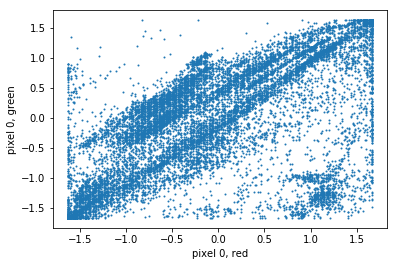

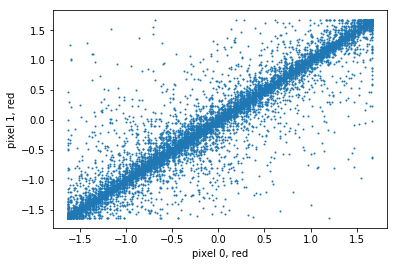

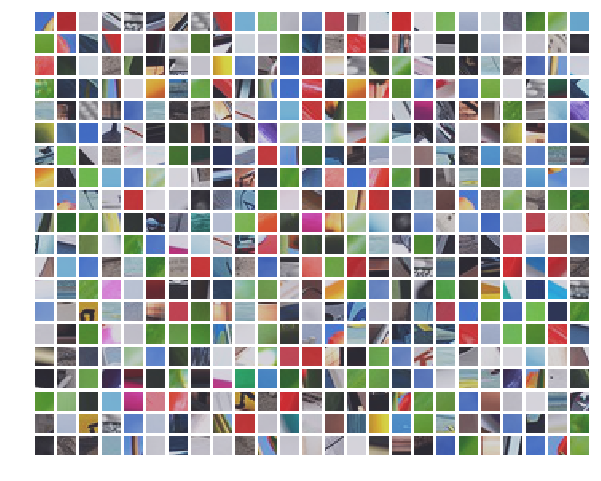

In [1]:
import utils
%matplotlib inline

# Load the dataset of image patches
X = utils.load()

# Plot the red vs. green channel of the first pixel
utils.scatterplot(X[:,0],X[:,1],xlabel='pixel 0, red',ylabel='pixel 0, green')

# Plot the red channel of the first and second pixel
utils.scatterplot(X[:,0],X[:,3],xlabel='pixel 0, red',ylabel='pixel 1, red')

# Visualize 500 image patches from the image
utils.render(X[:500])

## Whitening (10 P)

Independent component analysis applies whitening to the data as a preprocessing step. The whitened data matrix $\tilde X$ is obtained by linear projection of $X$, such data such that $\mathrm{E}[\tilde x \tilde x^\top] = I$, where $\tilde x$ is a row of the whitened matrix $\tilde X$. See Section 5.2 of the paper for a complete description of the whitening procedure.

**Tasks:**

* **Implement a function that returns a whitened version of the data given as input.**
* **Add to this function a test that makes sure that $\mathrm{E}[\tilde x \tilde x^\top] \approx I$ (up to numerical accuracy).**
* **Reproduce the scatter plots of the demo code, but this time, using the whitened data.**
* **Render 500 whitened image patches.**

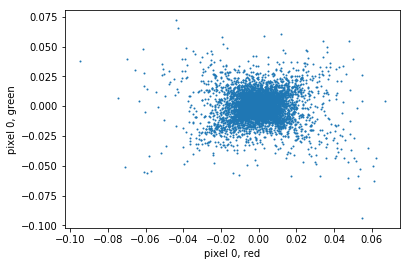

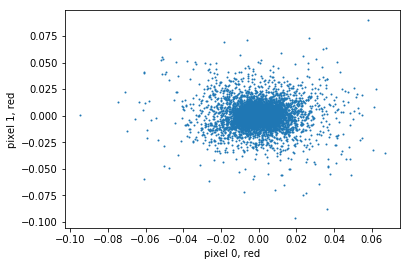

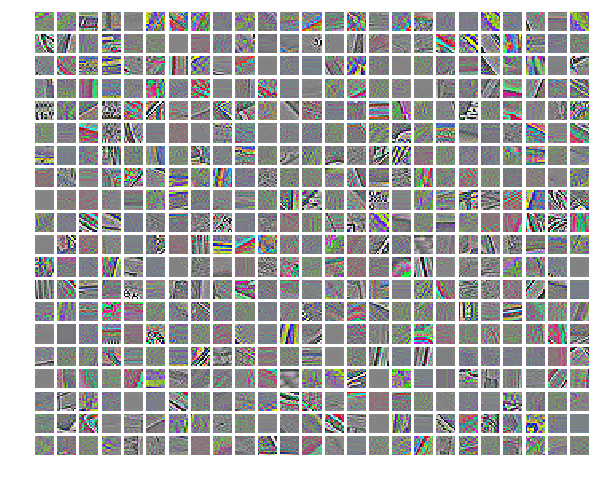

In [2]:
##### REPLACE BY YOUR CODE
import solutions
solutions.whitening()
#####

## Implementing FastICA (20 P)


We now would like to learn 100 independent components of the distribution of whitened image patches. For this, we follow the procedure described in the Chapter 6 of the paper. Implementation details specific to this exercise are given below:


* **Nonquadratic function G**: In this exercise, we will make use of the nonquadratic function $G(x) = \frac1a \log \cosh (a x)$, proposed in Section 4.3.2 of the paper, with $a=1.5$. This function admits as a derivative the function $g(x) = \tanh(a x)$, and as a double derivative the function $g'(x) = a \cdot (1-\tanh^2(a x))$.


* **Number of iterations**: The FastICA procedure will be run for 64 iterations. Note that the training procedure can take a relatively long time (up to 5 minutes depending on the system). Therefore, during the developement phase, it is advised to run the algorithm for a fraction of the total number of iterations.


* **Objective function**: The objective function that is maximized by the ICA training algorithm is given in Equation 25 of the paper. Note that since we learn 100 independent components, the objective function is in fact the *sum* of the objective functions of each independent components.


* **Finding multiple independent components**: Conceptually, finding multiple independent components as described in the paper is equivalent to running multiple instances of FastICA (one per independent component), under the constraint that the components learned by these instances are decorrelated. In order to keep the learning procedure computationally affordable, the code must be parallelized, in particular, make use of numpy matrix multiplications instead of loops whenever it is possible.


* **Weight decorrelation**: To decorrelate outputs, we use the inverse square root method given in Equation 45.


**Tasks:**

* **Implement the FastICA method described in the paper, and run it for 64 iterations.**

* **Print the value of the objective function at each iteration.**

* **Create a scatter plot of the projection of the whitened data on two distinct independent components after 0, 1, 3, 7, 15, 31, 63 iterations.**

* **Visualize the learned independent components using the function `render(...)`.**

In [ ]:
##### REPLACE BY YOUR CODE
import solutions
solutions.fastICA()
#####